In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

#### Some helper fns

In [130]:
categorical = lambda M: stats.rv_discrete(values=(xrange(M), stats.dirichlet([1] * M).rvs()[0]))
def one_hot(V, size):
    transformed = np.zeros((len(V), size))
    for i in xrange(transformed.shape[0]):
        transformed[i, V[i]] = 1
    return transformed

### Underlying generating process

#### Sample features

In [826]:
N = 5000
continuous_dim = 12
cat_size = 4

continuous_feats = np.random.randn(N, continuous_dim)
categorical_feat = ['State {}'.format(i) for i in categorical(cat_size).rvs(size=N)]

samples = np.column_stack([continuous_feats, categorical_feat])
samples.shape

(5000, 13)

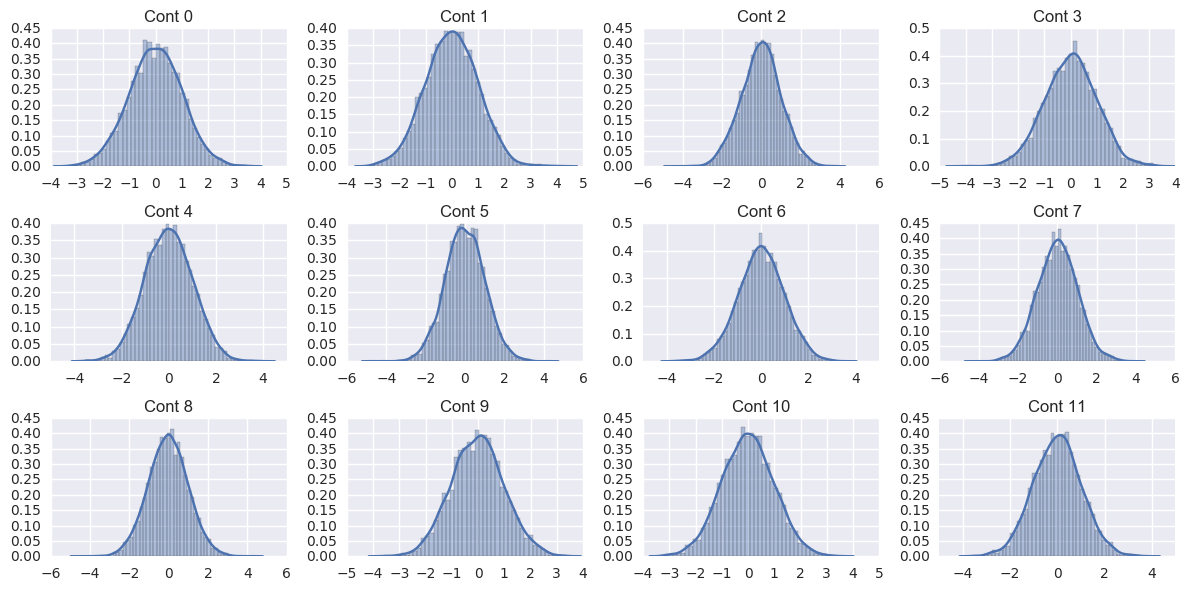

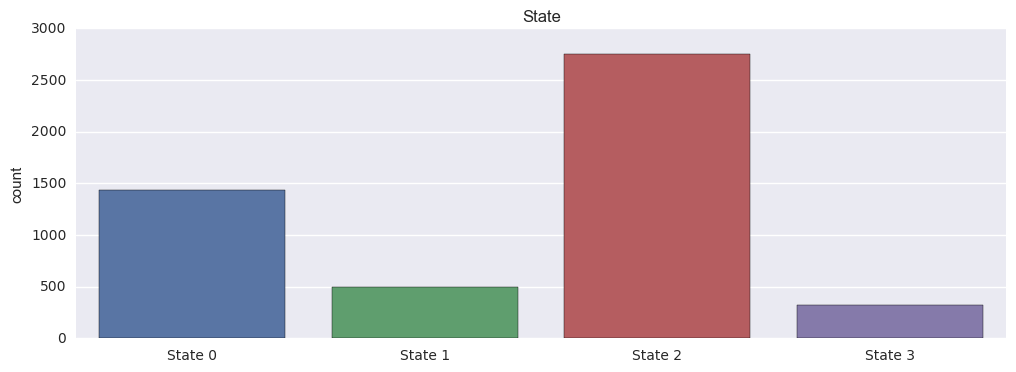

In [827]:
## Continuous
fig1 = plt.figure(figsize=(12, 6))
for i in xrange(continuous_feats.shape[1]):
    ax = fig1.add_subplot(3, 4, i+1)
    ax.set_title("Cont {}".format(i))
    sns.distplot(continuous_feats[:, i], ax=ax)

    
plt.tight_layout()
### Categoricals
fig2 = plt.figure(figsize=(12, 4))
ax1 = fig2.add_subplot(111)
sns.countplot(categorical_feat, ax=ax1, order=['State {}'.format(i) for i in xrange(cat_size)])
ax1.set_title('State')

#### Probability of being treated (we'll just use a linear relationship across the factors). Let's assume also that only people in state 2 are treated.

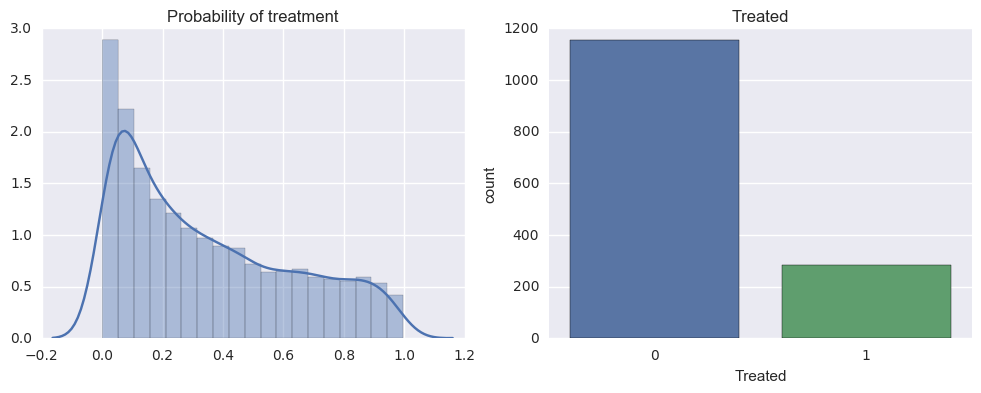

In [1017]:
sig = lambda t: 1 / (1 + np.exp(t+1)) 

state_filter = 'State 0'

z_true_coef = np.random.uniform(0, 1, size=continuous_dim)
raw_values = np.matmul(samples[:, :continuous_dim].astype(float), true_coef)
values = np.array([sig(x) for x in raw_values])
X = pd.DataFrame(samples, columns=['Cont {}'.format(i) for i in xrange(continuous_dim)] + ['State'])
X.loc[:, 'Z'] = values * (X['State'] == state_filter)
X.loc[:, 'Treated'] = X.Z.map(lambda p: stats.bernoulli(p * .5).rvs())


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Probability of treatment')
sns.distplot(values, ax=ax1)

ax2 = fig.add_subplot(122)
ax2.set_title('Treated')
sns.countplot(X[X.State == state_filter]['Treated'], ax=ax2)

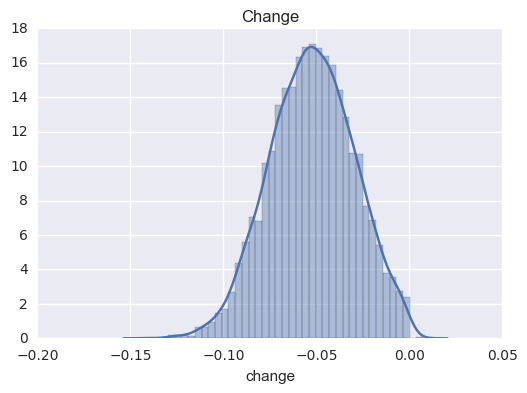

In [1157]:
X_encoded = pd.get_dummies(X, columns=["State"])
y_true_coef = np.random.uniform(-1, 0, size=X_encoded.shape[1])
X.loc[:, "Y_0"] = np.matmul(X_encoded.astype(float), y_true_coef)
X.loc[:, "perc_change"] = X.Z.map(lambda z: np.random.normal(z/50, 0.01)) + stats.norm(0.05, 0.02).rvs(size=X.shape[0])
X.loc[:, "Impact"] = np.abs(X.Y_0 * np.random.normal(0.005, 0.005)) * X.Treated
X.loc[:, "Y_1" ] = X.Y_0 - np.abs(X.Y_0 * X.perc_change) + X["Impact"]

X.loc[:, "change"] = (X.Y_1 - X.Y_0) / np.abs(X.Y_0)
ax = sns.distplot(X.change)
ax.set_title("Change")

### Comparison

#### The most naive approach would be to compare the outcome variable (Y) between merchants who receive the treatment, and those who didn't.

In [1171]:
def compare(control, treated):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    sns.distplot(treated.change, label="treated", ax=ax)
    sns.distplot(control.change, label="not treated", ax=ax)
    plt.legend(loc='best')
    
    print "Control mean: {}\nTreated mean: {}".format(control.change.mean(), treated.change.mean())
    print 'T-test: {}'.format(stats.ttest_ind(control.change, treated.change).pvalue)

Control mean: -0.0522770913369
Treated mean: -0.0536993316868
T-test: 0.302253299868


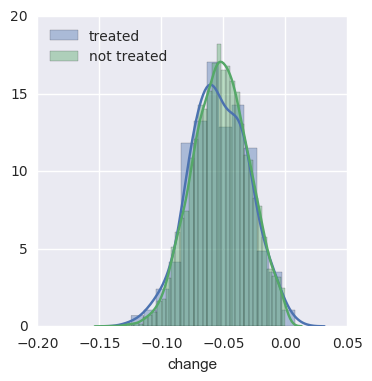

In [1172]:
control = X[X.Treated == 0]
treated = X[X.Treated == 1]
compare(control, treated)

#### After chatting with people that were involved in the experiment and validating this against the data, we see that only people from state 0 were treated. Let's how the change in Y compares between treated/non-treated units when limiting ourselves to those from this state.

Control mean: -0.0568156532608
Treated mean: -0.0536993316868
T-test: 0.0429051650042


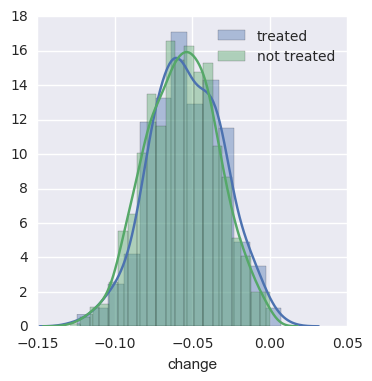

In [1173]:
state_0 = X[X.State == state_filter]
control = state_0[state_0.Treated == 0]
treated = state_0[state_0.Treated == 1]
compare(control, treated)

#### It looks like there's actually a  difference between the two distributions with $\mu_{treated}$ been higher than $\mu_{control}$, and using a t-test we would reject the null hypothesis at $\alpha: 0.05$. However, let's say that we are not just after chatting with more people, we suspect that there's a set of variables that were also considered when applying the treatment, that can also have an effect on Y...

In [1176]:
def _nearest_index(array, value):
    idx = np.searchsorted(array, value)
    below = value - array[max(0, idx-1)]
    above = array[min(len(array)-1, idx)] - value
    return idx if above < below else idx-1

### TODO: here we are using 'true Z'. This isn't something we usually have access to 

Control mean: -0.0624181375829
Treated mean: -0.0536993316868
T-test: 1.55528022638e-05


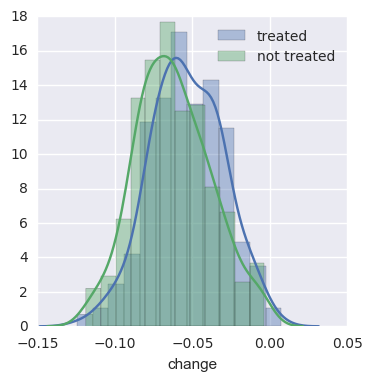

In [1177]:
state = X[X.State == state_filter]
state_treated = state[state.Treated == 1].sort_values(by="Z").reset_index()
state_not_treated = state[state.Treated == 0].sort_values(by="Z").reset_index()

state_treated.loc[:, "pair"] = state_treated.Z.map(lambda z: state_not_treated.ix[_nearest_index(state_not_treated.Z.values, z)]['index'])
synthetic_control = state.loc[state_treated.pair.values]

compare(synthetic_control, state_treated)